# Introduction

Hello, I'm **Wesley**, nice to meet you. 👋

For the past few notebooks, we've been using 🤗 **Hugging Face's Interface on 📖 Text Classification ([AutoModelForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification))** to train our classifiers. They made it **really easy** to hook up many **open-source large language models (LLM)** 🦙 and fine-tune 🔧 it to a particular domain to do a specific task. However, there are **situations where you would need to make a custom model** that fits your requirements. In this case, what you would need to do is to use the **Hugging Face's model as a base model** and add your own **task-specific layer/head** to it to do your specific goal 🥅.

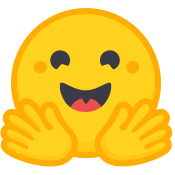

In this notebook, we will learn **how to use a Hugging Face base model and add your own custom task-specific layer/head**. We will be using **[DistilBert](https://huggingface.co/distilbert-base-uncased) as the base model** fine-tuning for a **4-way multi-class classification** with the [AG News dataset](https://huggingface.co/datasets/ag_news) to classify news topics 📰.

# Setup Python Libraries

In [24]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm torchinfo scikit-learn matplotlib nltk wordcloud --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate|^tqdm|^torchinfo|^scikit-learn|^matplotlib|^nltk|^wordcloud'

datasets==2.1.0
evaluate==0.4.0
matplotlib==3.7.1
matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/work
matplotlib-venn==0.11.9
nltk==3.2.4
numpy==1.23.5
scikit-learn==1.2.2
scikit-learn-intelex==2023.1.1
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=de0c947f8c06a637392b3efa76aad3ac1d91effd6481f8154aeeb4303f12d133
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=178c0fd167dd56970d14aa26ff4e98d8963ead026f00b4f36d6d7fc93421f317
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==1.0.0
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=89c1e3cb8aa36dc34a82501799a7d364ca4a4f6d447d86324a9aec7036fa4702
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=4ed53c3d788b3394127da0e3207891e604d52f3b7ea69e5be0a895cc6029ed4a
tqdm @ file:///home/conda/feedstock_root/build_artifacts/tqdm_1677948868469/work
transformers==4.28.

# Create Dataset

## Set Seed for Reproducibility

In [25]:
import torch
import numpy as np

# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Clone Raw Dataset

In [26]:
from datasets import load_dataset

# let's clone the dataset
# source: https://huggingface.co/datasets/ag_news
raw_datasets = load_dataset('ag_news')
raw_datasets

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [27]:
# let's print out one example
raw_datasets['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

## Get Target Label Information

In [28]:
# let's get the label information
NUM_LABELS = 0
ID2LABEL = {}
LABEL2ID = {}

for idx,label in enumerate(raw_datasets['train'].features['label'].names):
    NUM_LABELS += 1
    ID2LABEL[idx] = label
    LABEL2ID[label] = idx

print(f"NUM_LABELS: {NUM_LABELS}")
print(f"ID2LABEL: {ID2LABEL}")
print(f"LABEL2ID: {LABEL2ID}")

NUM_LABELS: 4
ID2LABEL: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
LABEL2ID: {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


## Split Datasets

In [29]:
# let's split the datasets to train-validation-test
new_datasets = raw_datasets['train'].train_test_split(test_size=0.1, seed=SEED, shuffle=True)
new_datasets['validation'] = new_datasets.pop('test')
new_datasets['test'] = raw_datasets['test']
new_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

## Plot Wordclouds

In [30]:
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from tqdm.notebook import tqdm
from collections import Counter

stopwords_set = set(stopwords.words('english')).union(STOPWORDS)

word_counters = {label:Counter() for label in LABEL2ID.keys()}

for split_type in new_datasets.keys():
    for example in tqdm(new_datasets[split_type]):
        word_list = list(filter(lambda x: x.isalpha() and x not in stopwords_set, map(lambda x: x.lower(), wordpunct_tokenize(example['text']))))
        word_counters[ID2LABEL[example['label']]].update(word_list)

  0%|          | 0/108000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_wordcloud(word_counter, title):
    wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(frequencies=word_counter)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

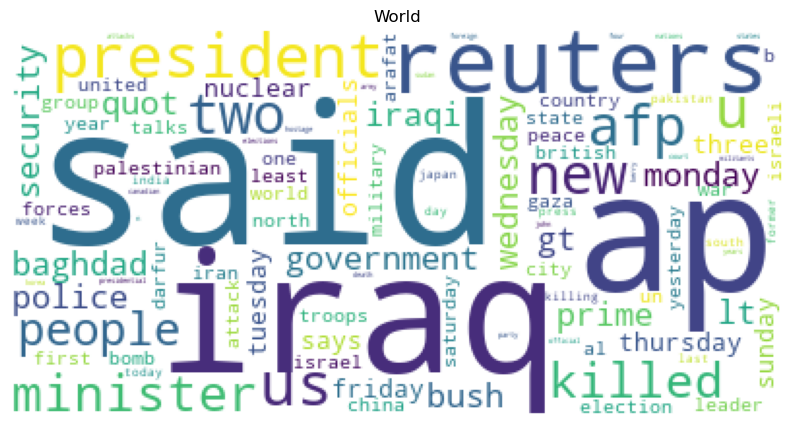

In [32]:
plot_wordcloud(word_counters['World'], 'World')

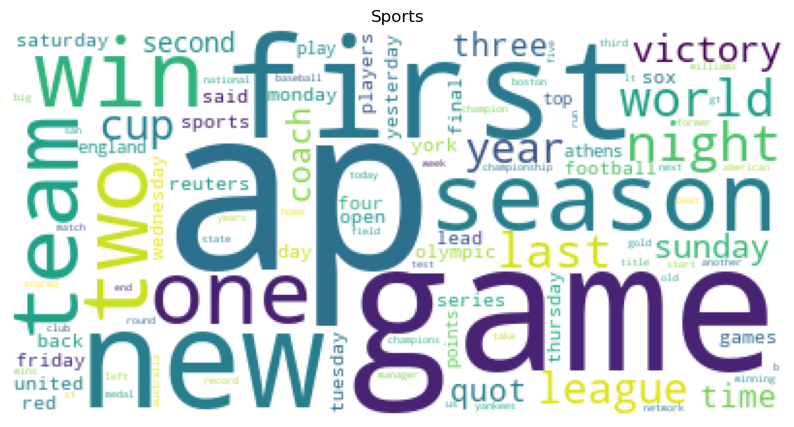

In [33]:
plot_wordcloud(word_counters['Sports'], 'Sports')

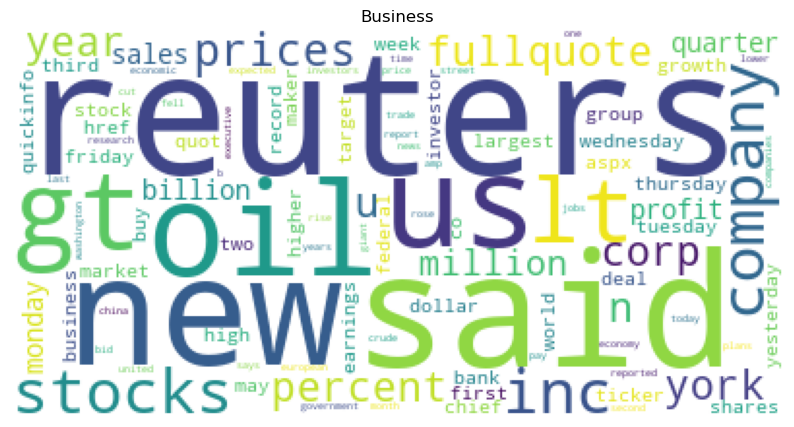

In [34]:
plot_wordcloud(word_counters['Business'], 'Business')

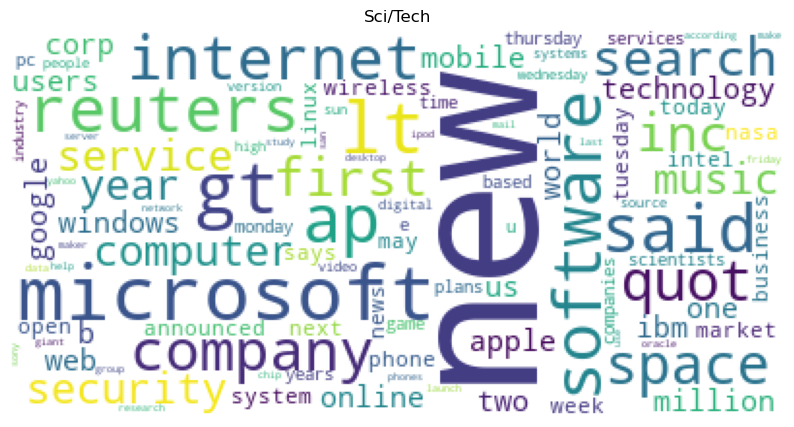

In [35]:
plot_wordcloud(word_counters['Sci/Tech'], 'Sci/Tech')

## Tokenize Dataset

In [36]:
from transformers import AutoTokenizer

CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

def encode(batch):
    encoded_batch = tokenizer(batch['text'], truncation=True)
    encoded_batch['labels'] = batch['label']
    return encoded_batch

# let's add on-the-fly tokenizing to reduce ram usage
new_datasets.set_transform(encode)

## Setup Data Collator and Data Loaders

In [37]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# get default data collator with dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# setup dataloaders with reduced datasets
dataloaders = {}
for split_type in new_datasets.keys():
    dataloaders[split_type] = DataLoader(
        dataset=new_datasets[split_type].select(range(10_000 if split_type=='train' else 1_000)),
        batch_size=32,
        shuffle=(split_type=='train'),
        collate_fn=data_collator,
    )

# Create Custom Model

## Clone Base Model

In [38]:
from transformers import AutoModel
from torchinfo import summary

# clone the base DistilBert model from hugging face hub
# source: https://huggingface.co/distilbert-base-uncased
base_model = AutoModel.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

# let's see the layers and number of trainable parameters
display(base_model)
summary(base_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

Layer (type:depth-idx)                             Param #
DistilBertModel                                    --
├─Embeddings: 1-1                                  --
│    └─Embedding: 2-1                              23,440,896
│    └─Embedding: 2-2                              393,216
│    └─LayerNorm: 2-3                              1,536
│    └─Dropout: 2-4                                --
├─Transformer: 1-2                                 --
│    └─ModuleList: 2-5                             --
│    │    └─TransformerBlock: 3-1                  7,087,872
│    │    └─TransformerBlock: 3-2                  7,087,872
│    │    └─TransformerBlock: 3-3                  7,087,872
│    │    └─TransformerBlock: 3-4                  7,087,872
│    │    └─TransformerBlock: 3-5                  7,087,872
│    │    └─TransformerBlock: 3-6                  7,087,872
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0

## Get Current Device

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"DEVICE: {device}")

DEVICE: cuda


In [40]:
from torch import nn

# we get the hidden size of the model from the embeddings
HIDDEN_SIZE = base_model.embeddings.word_embeddings.embedding_dim

# let's create a custom model to classify news topics
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = HIDDEN_SIZE
        self.num_labels = NUM_LABELS
        self.base_model = base_model
        self.classifier = nn.Linear(self.hidden_size, self.num_labels)
        
    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # get the CLS token of the last hidden state 
        x = x.last_hidden_state[:,0,:]
        x = self.classifier(x)
        return x
    
model = CustomModel().to(device)

display(model)
summary(model)

CustomModel(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

Layer (type:depth-idx)                                  Param #
CustomModel                                             --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           3,076
Total params: 66,365,956
Trainable params: 66,365,956
Non-trainable params: 0

# Train Model

## Setup Training Loops

In [41]:
import evaluate

f1_metric = evaluate.load('f1')

# let's setup train loop
def train(model, dataloader, loss_fn, optimizer):
    # setup metric variables
    train_loss = 0.
    
    # enable gradient computing
    model.train()
    for batch in tqdm(dataloader, leave=False):
        # reset gradients
        optimizer.zero_grad()
        
        # move inputs to batch
        batch = batch.to(device)
        
        # get prediction and loss
        pred = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = loss_fn(pred, batch['labels'])
        
        # compute gradients using loss and update weights
        loss.backward()
        optimizer.step()
        
        # accumulate metrics
        train_loss += loss.item()
        
    # compute metrics
    train_loss /= len(dataloader)
    return {'loss': train_loss}

# let's setup a evaluate loop
def evaluate(model, dataloader, loss_fn):
    # setup metric variables
    evaluate_loss = 0.
    evaluate_accuracy = 0.
    true_labels = []
    predicted_labels = []
    
    # disable gradient computing
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, leave=False):
            # move batch to device
            batch = batch.to(device)
            
            # get predictions
            preds = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            # accumulate metrics
            evaluate_loss += loss_fn(preds, batch['labels']).item()
            evaluate_accuracy += (preds.argmax(-1)==batch['labels']).type(torch.float).sum().item()
            f1_metric.add_batch(predictions=preds.argmax(-1), references=batch['labels'])
            
    # compute metrics
    evaluate_loss /= len(dataloader)
    evaluate_accuracy /= len(dataloader.dataset)
    evaluate_f1 = f1_metric.compute(average='macro')['f1']
    
    return {'loss': evaluate_loss, 'accuracy': evaluate_accuracy, 'f1': evaluate_f1}

## Setup Training Configurations

In [42]:
from torch.optim import AdamW

# we use the loss function CrossEntropyLoss as it's Log Softmax (LogSoftmax) + Negative Log Likelihood Loss (NLLLoss) 
loss_fn = nn.CrossEntropyLoss()
# we use the Adam optimizer with a low learning rate and no weight decay
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0)

## Train Model

In [43]:
# we train/fine-tune the model for 5 epochs
# and store their results for later plotting
train_metrics_list = []
validation_metrics_list = []

num_epochs = 3
for epoch in range(num_epochs):
    train_metrics = train(model, dataloaders['train'], loss_fn, optimizer)
    validation_metrics = evaluate(model, dataloaders['validation'], loss_fn)
    train_metrics_list.append(train_metrics)
    validation_metrics_list.append(validation_metrics)
    print(f"EPOCH {epoch+1}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.4f}", end=" | ")
    print(f"VALIDATION LOSS: {validation_metrics['loss']:.4f}", end=" | ")
    print(f"VALIDATION ACCURACY: {validation_metrics['accuracy']:.4f}", end=" | ")
    print(f"VALIDATION F1: {validation_metrics['f1']:.4f}", end=" | ")

  0%|          | 0/313 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/32 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.3260 | VALIDATION LOSS: 0.3056 | VALIDATION ACCURACY: 0.8990 | VALIDATION F1: 0.8995 | 

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

EPOCH 2 | TRAIN LOSS: 0.1648 | VALIDATION LOSS: 0.3104 | VALIDATION ACCURACY: 0.8950 | VALIDATION F1: 0.8956 | 

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

EPOCH 3 | TRAIN LOSS: 0.0891 | VALIDATION LOSS: 0.3598 | VALIDATION ACCURACY: 0.8900 | VALIDATION F1: 0.8913 | 

## Plot Train Results

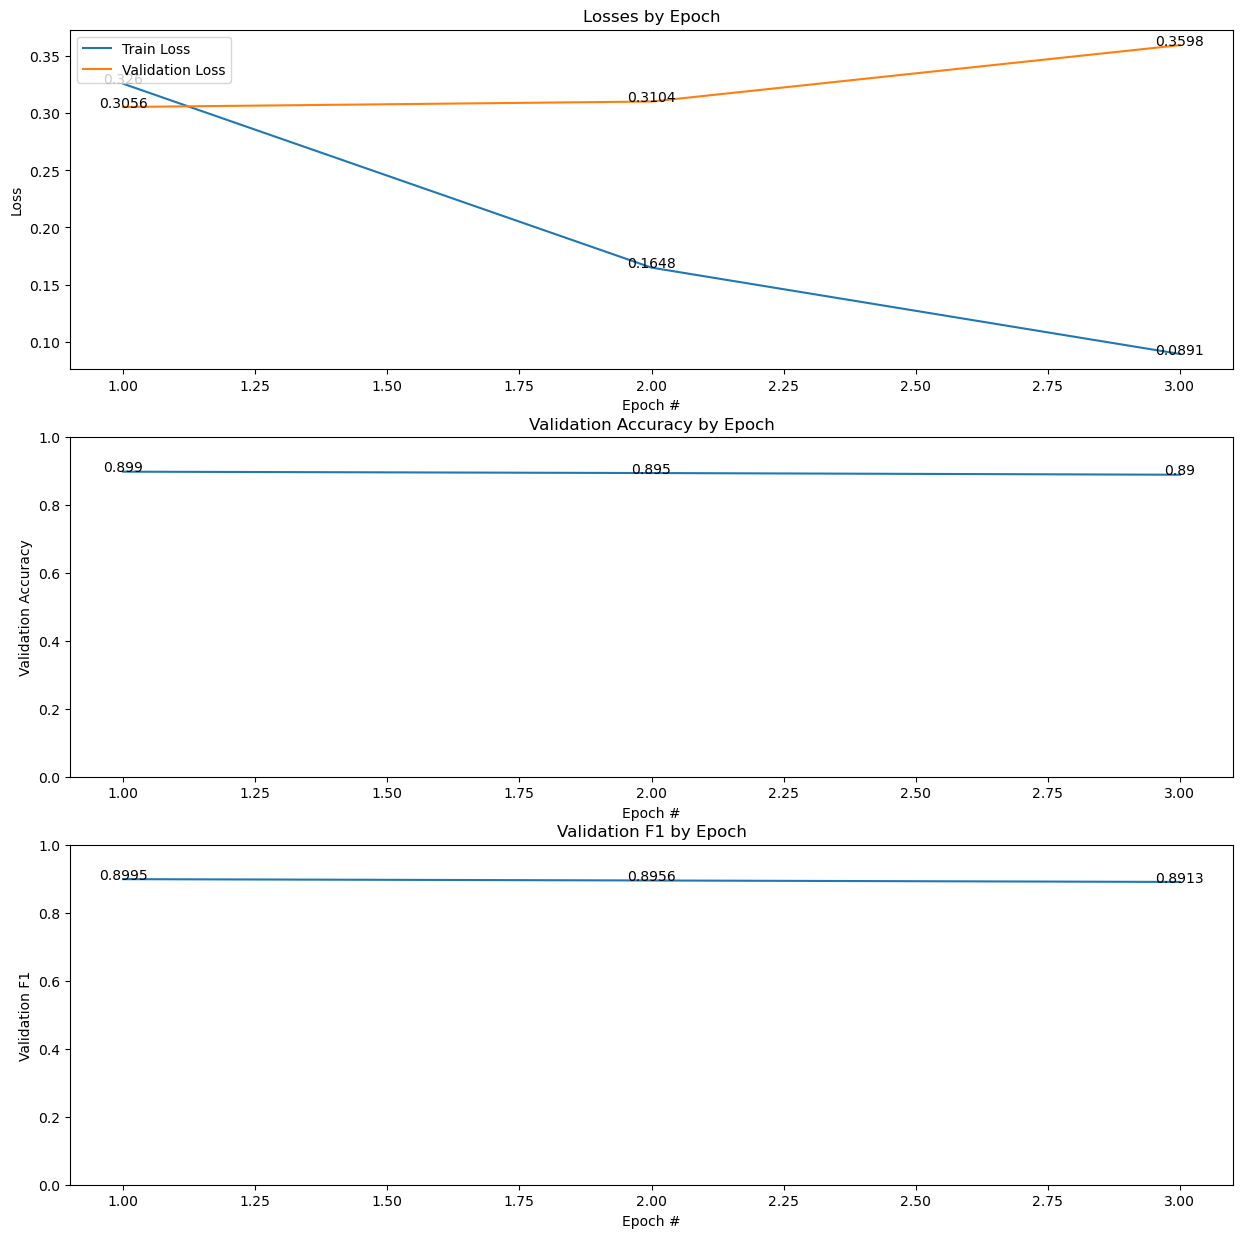

In [44]:
# let's parse the results out
epoch_list = []
train_loss_list = []
validation_loss_list = []
validation_accuracy_list = []
validation_f1_list = []
for idx,(train_metrics,validation_metrics) in enumerate(zip(train_metrics_list, validation_metrics_list)):
    epoch_list.append(idx+1)
    train_loss_list.append(float(f"{train_metrics['loss']:.4f}"))
    validation_loss_list.append(float(f"{validation_metrics['loss']:.4f}"))
    validation_accuracy_list.append(float(f"{validation_metrics['accuracy']:.4f}"))
    validation_f1_list.append(float(f"{validation_metrics['f1']:.4f}"))

# we combine all metrics into a multiplot
fig, axs = plt.subplots(nrows=3, figsize=(15,15))
xlabel = 'Epoch #'

# we plot the losses
axs[0].set_title('Losses by Epoch')
axs[0].plot(epoch_list, train_loss_list)
axs[0].plot(epoch_list, validation_loss_list)
axs[0].set(xlabel=xlabel, ylabel='Loss')
axs[0].legend(['Train Loss', 'Validation Loss'])
for i in range(len(epoch_list)):
    axs[0].text(x=i+1, y=train_loss_list[i], s=train_loss_list[i], ha='center')
    axs[0].text(x=i+1, y=validation_loss_list[i], s=validation_loss_list[i], ha='center')

# we plot the accuracies
axs[1].set_title('Validation Accuracy by Epoch')
axs[1].plot(epoch_list, validation_accuracy_list)
axs[1].set(xlabel=xlabel, ylabel='Validation Accuracy')
axs[1].set_ylim(0,1)
for i in range(len(epoch_list)):
    axs[1].text(x=i+1, y=validation_accuracy_list[i], s=validation_accuracy_list[i], ha='center')
    
# we plot the f1
axs[2].set_title('Validation F1 by Epoch')
axs[2].plot(epoch_list, validation_f1_list)
axs[2].set(xlabel=xlabel, ylabel='Validation F1')
axs[2].set_ylim(0,1)
for i in range(len(epoch_list)):
    axs[2].text(x=i+1, y=validation_f1_list[i], s=validation_f1_list[i], ha='center')

# Error Analysis

## Get Test Performance

In [45]:
# let's get the performance on the test set
test_accuracy = 0.
test_f1 = 0.
y_true_list = []
y_pred_list = []

# set to eval mode
model.eval()
with torch.no_grad():
    for batch in tqdm(dataloaders['test'], leave=False):
        # move to current device
        batch = batch.to(device)
        
        # get predictions
        preds = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        
        # accumulate metrics
        test_accuracy += (preds.argmax(-1)==batch['labels']).type(torch.float).sum().item()
        f1_metric.add_batch(predictions=preds.argmax(-1), references=batch['labels'])
        
        # keep for confusion matrix
        y_pred_list += preds.argmax(-1).tolist()
        y_true_list += batch['labels'].tolist()
        
    test_accuracy /= len(dataloaders['test'].dataset)
    test_f1 = f1_metric.compute(average='macro')['f1']
    
print(f"TEST_ACCURACY: {test_accuracy}")
print(f"TEST_F1: {test_f1}")

  0%|          | 0/32 [00:00<?, ?it/s]

TEST_ACCURACY: 0.896
TEST_F1: 0.8920553131762587


## Plot Confusion Matrix

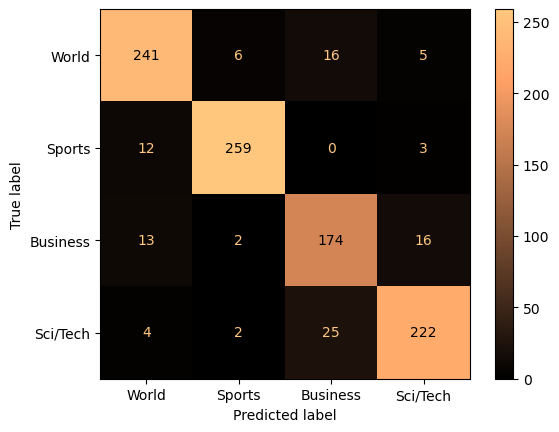

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plot test confusion matrix
test_confusion_matrix = confusion_matrix(y_true_list, y_pred_list, labels=list(ID2LABEL.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=list(ID2LABEL.values()))
disp.plot(cmap='copper')

plt.show()

# Conclusion
- Based on the reduction in train loss but increasing validation loss, we are currently overfitting.
- Validation accuracy (89%) and f1 (89%) are similar across the training epochs.
- Test accuracy (89.6%) and f1 (89.2%) are similar to validation, which is good.
- Based on the confusion matrix,
 - we see that some Sci/Tech news are being classified as Business (25), this also happens vice-versa (16)
 - we see that some World news are being classified as Business (16), this also happens vice-versa (13)
 - we see more Sports news being classified as World (12) than the vice-versa (6)
 - we see no confusion on classifying Sports to Business news (0)